In [1]:
from typing import List, Optional, Tuple

import numpy as np

from l5kit.data import (
    TL_FACE_DTYPE,
    filter_agents_by_labels,
    filter_tl_faces_by_frames,
    get_agents_slice_from_frames,
    get_tl_faces_slice_from_frames,
)
from l5kit.data.filter import filter_agents_by_frames, filter_agents_by_track_id
from l5kit.geometry import angular_distance, rotation33_as_yaw
from l5kit.kinematic import Perturbation
from l5kit.sampling.slicing import get_future_slice, get_history_slice
from l5kit.rasterization import EGO_EXTENT_HEIGHT, EGO_EXTENT_LENGTH, EGO_EXTENT_WIDTH


def generate_agent_sample(
    state_index: int,
    frames: np.ndarray,
    agents: np.ndarray,
    tl_faces: np.ndarray,
    selected_track_id: Optional[int],
    history_num_frames: int,
    history_step_size: int,
    future_num_frames: int,
    future_step_size: int,
    filter_agents_threshold: float,
    perturbation: Optional[Perturbation] = None,
) -> dict:
    """Generates the inputs and targets to train a deep prediction model. A deep prediction model takes as input
    the state of the world (here: an image we will call the "raster"), and outputs where that agent will be some
    seconds into the future.
    This function has a lot of arguments and is intended for internal use, you should try to use higher level classes
    and partials that use this function.
    Args:
        state_index (int): The anchor frame index, i.e. the "current" timestep in the scene
        frames (np.ndarray): The scene frames array, can be numpy array or a zarr array
        agents (np.ndarray): The full agents array, can be numpy array or a zarr array
        tl_faces (np.ndarray): The full traffic light faces array, can be numpy array or a zarr array
        selected_track_id (Optional[int]): Either None for AV, or the ID of an agent that you want to
        predict the future of. This agent is centered in the raster and the returned targets are derived from
        their future states.
        history_num_frames (int): Amount of history frames to draw into the rasters
        history_step_size (int): Steps to take between frames, can be used to subsample history frames
        future_num_frames (int): Amount of history frames to draw into the rasters
        future_step_size (int): Steps to take between targets into the future
        filter_agents_threshold (float): Value between 0 and 1 to use as cutoff value for agent filtering
        based on their probability of being a relevant agent
        perturbation (Optional[Perturbation]): Object that perturbs the input and targets, used
to train models that can recover from slight divergence from training set data
    Raises:
        ValueError: A ValueError is returned if the specified ``selected_track_id`` is not present in the scene
        or was filtered by applying the ``filter_agent_threshold`` probability filtering.
    Returns:
        dict: a dict object with the raster array, the future offset coordinates (meters),
        the future yaw angular offset, the future_availability as a binary mask
    """
    #  the history slice is ordered starting from the latest frame and goes backward in time., ex. slice(100, 91, -2)
    history_slice = get_history_slice(state_index, history_num_frames, history_step_size, include_current_state=True)
    future_slice = get_future_slice(state_index, future_num_frames, future_step_size)

    history_frames = frames[history_slice].copy()  # copy() required if the object is a np.ndarray
    future_frames = frames[future_slice].copy()

    sorted_frames = np.concatenate((history_frames[::-1], future_frames))  # from past to future

    # get agents (past and future)
    agent_slice = get_agents_slice_from_frames(sorted_frames[0], sorted_frames[-1])
    agents = agents[agent_slice].copy()  # this is the minimum slice of agents we need
    history_frames["agent_index_interval"] -= agent_slice.start  # sync interval with the agents array
    future_frames["agent_index_interval"] -= agent_slice.start  # sync interval with the agents array
    history_agents = filter_agents_by_frames(history_frames, agents)
    future_agents = filter_agents_by_frames(future_frames, agents)

    try:
        tl_slice = get_tl_faces_slice_from_frames(history_frames[-1], history_frames[0])  # -1 is the farthest
        # sync interval with the traffic light faces array
        history_frames["traffic_light_faces_index_interval"] -= tl_slice.start
        history_tl_faces = filter_tl_faces_by_frames(history_frames, tl_faces[tl_slice].copy())
    except ValueError:
        history_tl_faces = [np.empty(0, dtype=TL_FACE_DTYPE) for _ in history_frames]

    if perturbation is not None:
        history_frames, future_frames = perturbation.perturb(
            history_frames=history_frames, future_frames=future_frames
        )

    # State you want to predict the future of.
    cur_frame = history_frames[0]
    cur_agents = history_agents[0]

    if selected_track_id is None:
        agent_centroid = cur_frame["ego_translation"][:2]
        agent_yaw = rotation33_as_yaw(cur_frame["ego_rotation"])
        agent_extent = np.asarray((EGO_EXTENT_LENGTH, EGO_EXTENT_WIDTH, EGO_EXTENT_HEIGHT))
        selected_agent = None
        agent_label_probabilities = None
        agent_velocity = None
    else:
        # this will raise IndexError if the agent is not in the frame or under agent-threshold
        # this is a strict error, we cannot recover from this situation
        try:
            agent = filter_agents_by_track_id(
                filter_agents_by_labels(cur_agents, filter_agents_threshold), selected_track_id
            )[0]
        except IndexError:
            raise ValueError(f" track_id {selected_track_id} not in frame or below threshold")
        agent_centroid = agent["centroid"]
        agent_yaw = float(agent["yaw"])
        agent_extent = agent["extent"]
        selected_agent = agent
        agent_label_probabilities = agent["label_probabilities"]
        agent_velocity = agent["velocity"]

    future_coords_offset, future_yaws_offset, future_availability, _ = _create_targets_for_deep_prediction(
        future_num_frames, future_frames, selected_track_id, future_agents, agent_centroid[:2], agent_yaw,
    )

    # history_num_frames + 1 because it also includes the current frame
    history_coords_offset, history_yaws_offset, history_availability, history_velocities = _create_targets_for_deep_prediction(
        history_num_frames + 1, history_frames, selected_track_id, history_agents, agent_centroid[:2], agent_yaw,
    )

    return {
        "target_positions": future_coords_offset,
        "target_yaws": future_yaws_offset,
        "target_availabilities": future_availability,
        "history_positions": history_coords_offset,
        "history_yaws": history_yaws_offset,
        "history_availabilities": history_availability,
        "centroid": agent_centroid,
        "yaw": agent_yaw,
        "extent": agent_extent,
        "label_probabilities": agent_label_probabilities,
        "history_velocities": history_velocities
    }


def _create_targets_for_deep_prediction(
    num_frames: int,
    frames: np.ndarray,
    selected_track_id: Optional[int],
    agents: List[np.ndarray],
    agent_current_centroid: np.ndarray,
    agent_current_yaw: float,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Internal function that creates the targets and availability masks for deep prediction-type models.
    The futures/history offset (in meters) are computed. When no info is available (e.g. agent not in frame)
    a 0 is set in the availability array (1 otherwise).
    Args:
        num_frames (int): number of offset we want in the future/history
        frames (np.ndarray): available frames. This may be less than num_frames
        selected_track_id (Optional[int]): agent track_id or AV (None)
        agents (List[np.ndarray]): list of agents arrays (same len of frames)
        agent_current_centroid (np.ndarray): centroid of the agent at timestep 0
        agent_current_yaw (float): angle of the agent at timestep 0
    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: position offsets, angle offsets, availabilities
    """
    # How much the coordinates differ from the current state in meters.
    coords_offset = np.zeros((num_frames, 2), dtype=np.float32)
    velocities = np.zeros((num_frames, 2), dtype=np.float32)
    yaws_offset = np.zeros((num_frames, 1), dtype=np.float32)
    availability = np.zeros((num_frames,), dtype=np.float32)

    for i, (frame, agents) in enumerate(zip(frames, agents)):
        if selected_track_id is None:
            agent_centroid = frame["ego_translation"][:2]
            agent_yaw = rotation33_as_yaw(frame["ego_rotation"])
            agent_velocity = None
        else:
            # it's not guaranteed the target will be in every frame
            try:
                agent = filter_agents_by_track_id(agents, selected_track_id)[0]
            except IndexError:
                availability[i] = 0.0  # keep track of invalid futures/history
                continue

            agent_centroid = agent["centroid"]
            agent_yaw = agent["yaw"]
            agent_velocity = agent["velocity"]

        coords_offset[i] = agent_centroid - agent_current_centroid
        velocities[i] = agent_velocity
        yaws_offset[i] = angular_distance(agent_yaw, agent_current_yaw)
        availability[i] = 1.0
    return coords_offset, yaws_offset, availability, velocities[:num_frames - 1,:]

In [2]:
import bisect
from functools import partial
from typing import Optional, Tuple, cast

import numpy as np
from torch.utils.data import Dataset

from l5kit.data import (
    ChunkedDataset,
    get_agents_slice_from_frames,
    get_frames_slice_from_scenes,
    get_tl_faces_slice_from_frames,
)


class EgoDatasetModified(Dataset):
    def __init__(
        self,
        cfg: dict,
        zarr_dataset: ChunkedDataset,
    ):
        """
        Get a PyTorch dataset object that can be used to train DNN
        Args:
            cfg (dict): configuration file
            zarr_dataset (ChunkedDataset): the raw zarr dataset
        """
        self.cfg = cfg
        self.dataset = zarr_dataset

        self.cumulative_sizes = self.dataset.scenes["frame_index_interval"][:, 1]

        # build a partial so we don't have to access cfg each time
        self.sample_function = partial(
            generate_agent_sample,
            history_num_frames=cfg["model_params"]["history_num_frames"],
            history_step_size=cfg["model_params"]["history_step_size"],
            future_num_frames=cfg["model_params"]["future_num_frames"],
            future_step_size=cfg["model_params"]["future_step_size"],
            filter_agents_threshold=cfg["raster_params"]["filter_agents_threshold"],
            perturbation=None,
        )

    def __len__(self) -> int:
        """
        Get the number of available AV frames
        Returns:
            int: the number of elements in the dataset
        """
        return len(self.dataset.frames)

    def get_frame(self, scene_index: int, state_index: int, track_id: Optional[int] = None) -> dict:
        """
        A utility function to get the rasterisation and trajectory target for a given agent in a given frame
        Args:
            scene_index (int): the index of the scene in the zarr
            state_index (int): a relative frame index in the scene
            track_id (Optional[int]): the agent to rasterize or None for the AV
        Returns:
            dict: the rasterised image, the target trajectory (position and yaw) along with their availability,
            the 2D matrix to center that agent, the agent track (-1 if ego) and the timestamp
        """
        frames = self.dataset.frames[get_frames_slice_from_scenes(self.dataset.scenes[scene_index])]
        data = self.sample_function(state_index, frames, self.dataset.agents, self.dataset.tl_faces, track_id)

        target_positions = np.array(data["target_positions"], dtype=np.float32)
        target_yaws = np.array(data["target_yaws"], dtype=np.float32)

        history_positions = np.array(data["history_positions"], dtype=np.float32)
        history_velocities = np.array(data["history_velocities"], dtype=np.float32)
        history_yaws = np.array(data["history_yaws"], dtype=np.float32)

        timestamp = frames[state_index]["timestamp"]
        track_id = np.int64(-1 if track_id is None else track_id)  # always a number to avoid crashing torch
            
        return {
            "target_positions": target_positions,
            "target_yaws": target_yaws,
            "target_availabilities": data["target_availabilities"],
            "history_positions": history_positions,
            "history_yaws": history_yaws,
            "history_availabilities": data["history_availabilities"],
            "track_id": track_id,
            "timestamp": timestamp,
            "centroid": data["centroid"],
            "yaw": data["yaw"],
            "extent": data["extent"],
            "label_probabilities": data["label_probabilities"],
            "history_velocities": history_velocities,
        }

    def __getitem__(self, index: int) -> dict:
        """
        Function called by Torch to get an element
        Args:
            index (int): index of the element to retrieve
        Returns: please look get_frame signature and docstring
        """
        if index < 0:
            if -index > len(self):
                raise ValueError("absolute value of index should not exceed dataset length")
            index = len(self) + index

        scene_index = bisect.bisect_right(self.cumulative_sizes, index)

        if scene_index == 0:
            state_index = index
        else:
            state_index = index - self.cumulative_sizes[scene_index - 1]
        return self.get_frame(scene_index, state_index)

    def get_scene_dataset(self, scene_index: int) -> "EgoDataset":
        """
        Returns another EgoDataset dataset where the underlying data can be modified.
        This is possible because, even if it supports the same interface, this dataset is np.ndarray based.
        Args:
            scene_index (int): the scene index of the new dataset
        Returns:
            EgoDataset: A valid EgoDataset dataset with a copy of the data
        """
        # copy everything to avoid references (scene is already detached from zarr if get_combined_scene was called)
        scenes = self.dataset.scenes[scene_index : scene_index + 1].copy()
        frame_slice = get_frames_slice_from_scenes(*scenes)
        frames = self.dataset.frames[frame_slice].copy()
        agent_slice = get_agents_slice_from_frames(*frames[[0, -1]])
        tl_slice = get_tl_faces_slice_from_frames(*frames[[0, -1]])

        agents = self.dataset.agents[agent_slice].copy()
        tl_faces = self.dataset.tl_faces[tl_slice].copy()

        frames["agent_index_interval"] -= agent_slice.start
        frames["traffic_light_faces_index_interval"] -= tl_slice.start
        scenes["frame_index_interval"] -= frame_slice.start

        dataset = ChunkedDataset("")
        dataset.agents = agents
        dataset.tl_faces = tl_faces
        dataset.frames = frames
        dataset.scenes = scenes

        return EgoDataset(self.cfg, dataset)

    def get_scene_indices(self, scene_idx: int) -> np.ndarray:
        """
        Get indices for the given scene. EgoDataset iterates over frames, so this is just a matter
        of finding the scene boundaries.
        Args:
            scene_idx (int): index of the scene
        Returns:
            np.ndarray: indices that can be used for indexing with __getitem__
        """
        scenes = self.dataset.scenes
        assert scene_idx < len(scenes), f"scene_idx {scene_idx} is over len {len(scenes)}"
        return np.arange(*scenes[scene_idx]["frame_index_interval"])

    def get_frame_indices(self, frame_idx: int) -> np.ndarray:
        """
        Get indices for the given frame. EgoDataset iterates over frames, so this will be a single element
        Args:
            frame_idx (int): index of the scene
        Returns:
            np.ndarray: indices that can be used for indexing with __getitem__
        """
        frames = self.dataset.frames
        assert frame_idx < len(frames), f"frame_idx {frame_idx} is over len {len(frames)}"
        return np.asarray((frame_idx,), dtype=np.int64)

    def __str__(self) -> str:
        return self.dataset.__str__()

In [3]:
import bisect
from pathlib import Path
from typing import Optional

import numpy as np
from zarr import convenience

from l5kit.data import ChunkedDataset, get_agents_slice_from_frames, get_frames_slice_from_scenes
from l5kit.dataset.select_agents import TH_DISTANCE_AV, TH_EXTENT_RATIO, TH_YAW_DEGREE, select_agents

# WARNING: changing these values impact the number of instances selected for both train and inference!
MIN_FRAME_HISTORY = 10  # minimum number of frames an agents must have in the past to be picked
MIN_FRAME_FUTURE = 1  # minimum number of frames an agents must have in the future to be picked


class AgentDatasetModified(EgoDatasetModified):
    def __init__(
        self,
        cfg: dict,
        zarr_dataset: ChunkedDataset,
        agents_mask: Optional[np.ndarray] = None,
        min_frame_history: int = MIN_FRAME_HISTORY,
        min_frame_future: int = MIN_FRAME_FUTURE,
    ):

        super(AgentDatasetModified, self).__init__(cfg, zarr_dataset)
        if agents_mask is None:  # if not provided try to load it from the zarr
            agents_mask = self.load_agents_mask()
            past_mask = agents_mask[:, 0] >= min_frame_history
            future_mask = agents_mask[:, 1] >= min_frame_future
            agents_mask = past_mask * future_mask

            if min_frame_history != MIN_FRAME_HISTORY:
                print(f"warning, you're running with custom min_frame_history of {min_frame_history}")
            if min_frame_future != MIN_FRAME_FUTURE:
                print(f"warning, you're running with custom min_frame_future of {min_frame_future}")
        else:
            print("warning, you're running with a custom agents_mask")

        # store the valid agents indexes
        self.agents_indices = np.nonzero(agents_mask)[0]
        # this will be used to get the frame idx from the agent idx
        self.cumulative_sizes_agents = self.dataset.frames["agent_index_interval"][:, 1]
        self.agents_mask = agents_mask

    def load_agents_mask(self) -> np.ndarray:
        """
        Loads a boolean mask of the agent availability stored into the zarr. Performs some sanity check against cfg.
        Returns: a boolean mask of the same length of the dataset agents
        """
        agent_prob = self.cfg["raster_params"]["filter_agents_threshold"]

        agents_mask_path = Path(self.dataset.path) / f"agents_mask/{agent_prob}"
        if not agents_mask_path.exists():  # don't check in root but check for the path
            print(
                f"cannot find the right config in {self.dataset.path},\n"
                f"your cfg has loaded filter_agents_threshold={agent_prob};\n"
                "but that value doesn't have a match among the agents_mask in the zarr\n"
                "Mask will now be generated for that parameter."
            )
            select_agents(
                self.dataset,
                agent_prob,
                th_yaw_degree=TH_YAW_DEGREE,
                th_extent_ratio=TH_EXTENT_RATIO,
                th_distance_av=TH_DISTANCE_AV,
            )

        agents_mask = convenience.load(str(agents_mask_path))  # note (lberg): this doesn't update root
        return agents_mask

    def __len__(self) -> int:
        """
        length of the available and reliable agents (filtered using the mask)
        Returns: the length of the dataset
        """
        return len(self.agents_indices)

    def __getitem__(self, index: int) -> dict:
        """
        Differs from parent by iterating on agents and not AV.
        """
        if index < 0:
            if -index > len(self):
                raise ValueError("absolute value of index should not exceed dataset length")
            index = len(self) + index

        index = self.agents_indices[index]
        track_id = self.dataset.agents[index]["track_id"]
        frame_index = bisect.bisect_right(self.cumulative_sizes_agents, index)
        scene_index = bisect.bisect_right(self.cumulative_sizes, frame_index)

        if scene_index == 0:
            state_index = frame_index
        else:
            state_index = frame_index - self.cumulative_sizes[scene_index - 1]
        return self.get_frame(scene_index, state_index, track_id=track_id)

    def get_scene_dataset(self, scene_index: int) -> "AgentDatasetModified":
        """
        Differs from parent only in the return type.
        Instead of doing everything from scratch, we rely on super call and fix the agents_mask
        """

        new_dataset = super(AgentDatasetModified, self).get_scene_dataset(scene_index).dataset

        # filter agents_bool values
        frame_interval = self.dataset.scenes[scene_index]["frame_index_interval"]
        # ASSUMPTION: all agents_index are consecutive
        start_index = self.dataset.frames[frame_interval[0]]["agent_index_interval"][0]
        end_index = self.dataset.frames[frame_interval[1] - 1]["agent_index_interval"][1]
        agents_mask = self.agents_mask[start_index:end_index].copy()

        return AgentDatasetModified(
            self.cfg, new_dataset, agents_mask  # overwrite the loaded one
        )

    def get_scene_indices(self, scene_idx: int) -> np.ndarray:
        """
        Get indices for the given scene. Here __getitem__ iterate over valid agents indices.
        This means ``__getitem__(0)`` matches the first valid agent in the dataset.
        Args:
            scene_idx (int): index of the scene
        Returns:
            np.ndarray: indices that can be used for indexing with __getitem__
        """
        scenes = self.dataset.scenes
        assert scene_idx < len(scenes), f"scene_idx {scene_idx} is over len {len(scenes)}"
        frame_slice = get_frames_slice_from_scenes(scenes[scene_idx])
        agent_slice = get_agents_slice_from_frames(*self.dataset.frames[frame_slice][[0, -1]])

        mask_valid_indices = (self.agents_indices >= agent_slice.start) * (self.agents_indices < agent_slice.stop)
        indices = np.nonzero(mask_valid_indices)[0]
        return indices

    def get_frame_indices(self, frame_idx: int) -> np.ndarray:
        """
        Get indices for the given frame. Here __getitem__ iterate over valid agents indices.
        This means ``__getitem__(0)`` matches the first valid agent in the dataset.
        Args:
            frame_idx (int): index of the scene
        Returns:
            np.ndarray: indices that can be used for indexing with __getitem__
        """
        frames = self.dataset.frames
        assert frame_idx < len(frames), f"frame_idx {frame_idx} is over len {len(frames)}"

        agent_slice = get_agents_slice_from_frames(frames[frame_idx])

        mask_valid_indices = (self.agents_indices >= agent_slice.start) * (self.agents_indices < agent_slice.stop)
        indices = np.nonzero(mask_valid_indices)[0]
        return indices

In [4]:
cfg = {'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 10, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}
cfg

{'format_version': 4,
 'model_params': {'model_architecture': 'resnet50',
  'history_num_frames': 10,
  'history_step_size': 1,
  'history_delta_time': 0.1,
  'future_num_frames': 50,
  'future_step_size': 1,
  'future_delta_time': 0.1},
 'raster_params': {'raster_size': [224, 224],
  'pixel_size': [0.5, 0.5],
  'ego_center': [0.25, 0.5],
  'map_type': 'py_semantic',
  'satellite_map_key': 'aerial_map/aerial_map.png',
  'semantic_map_key': 'semantic_map/semantic_map.pb',
  'dataset_meta_key': 'meta.json',
  'filter_agents_threshold': 0.5},
 'train_data_loader': {'key': 'scenes/sample.zarr',
  'batch_size': 12,
  'shuffle': True,
  'num_workers': 16},
 'val_data_loader': {'key': 'scenes/sample.zarr',
  'batch_size': 12,
  'shuffle': False,
  'num_workers': 16},
 'train_params': {'checkpoint_every_n_steps': 10000,
  'max_num_steps': 5,
  'eval_every_n_steps': 10000}}

In [5]:
from l5kit.data import LocalDataManager, ChunkedDataset
import os
os.environ["L5KIT_DATA_FOLDER"] = "input/"
dm = LocalDataManager(None)

In [40]:
train_cfg = cfg["train_data_loader"]
train_zarr = ChunkedDataset(dm.require('scenes/train.zarr')).open()
train_dataset = AgentDatasetModified(cfg, train_zarr)

In [41]:
len(train_dataset)

22496709

In [42]:
val_zarr = ChunkedDataset(dm.require('scenes/validate.zarr')).open()
val_dataset = AgentDatasetModified(cfg, val_zarr)
len(val_dataset)

21624612

In [44]:
train_full_zarr = ChunkedDataset(dm.require('scenes/train_full.zarr')).open()
train_full_dataset = AgentDatasetModified(cfg, train_full_zarr)
len(train_full_dataset)

191177863

In [28]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=1024, 
                             num_workers=30,
                             collate_fn=lambda x: x)

In [29]:
from tqdm.auto import tqdm
label_probs_list = []
for batch in tqdm(train_dataloader):    
    label_probs_list.extend([x['label_probabilities'] for x in batch])

Process Process-195:
Traceback (most recent call last):


  File "/home/raman/anaconda3/envs/trajectory/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdf155bba70>
Traceback (most recent call last):
  File "/home/raman/anaconda3/envs/trajectory/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/raman/anaconda3/envs/trajectory/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/raman/anaconda3/envs/trajectory/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/raman/anaconda3/envs/trajectory/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/raman/anaconda3/envs/trajectory/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, 

KeyboardInterrupt: 

  File "/home/raman/anaconda3/envs/trajectory/lib/python3.7/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/home/raman/anaconda3/envs/trajectory/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/raman/anaconda3/envs/trajectory/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/raman/anaconda3/envs/trajectory/lib/python3.7/multiprocessing/queues.py", line 192, in _finalize_join
    thread.join()
  File "/home/raman/anaconda3/envs/trajectory/lib/python3.7/threading.py", line 1044, in join
    self._wait_for_tstate_lock()
  File "/home/raman/anaconda3/envs/trajectory/lib/python3.7/threading.py", line 1060, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt


In [30]:
label_probs_all = np.vstack(label_probs_list)

In [31]:
import pandas as pd

label_probs_df = pd.DataFrame(label_probs_all, columns=[
    "PERCEPTION_LABEL_NOT_SET",
    "PERCEPTION_LABEL_UNKNOWN",
    "PERCEPTION_LABEL_DONTCARE",
    "PERCEPTION_LABEL_CAR",
    "PERCEPTION_LABEL_VAN",
    "PERCEPTION_LABEL_TRAM",
    "PERCEPTION_LABEL_BUS",
    "PERCEPTION_LABEL_TRUCK",
    "PERCEPTION_LABEL_EMERGENCY_VEHICLE",
    "PERCEPTION_LABEL_OTHER_VEHICLE",
    "PERCEPTION_LABEL_BICYCLE",
    "PERCEPTION_LABEL_MOTORCYCLE",
    "PERCEPTION_LABEL_CYCLIST",
    "PERCEPTION_LABEL_MOTORCYCLIST",
    "PERCEPTION_LABEL_PEDESTRIAN",
    "PERCEPTION_LABEL_ANIMAL",
    "AVRESEARCH_LABEL_DONTCARE",
])

In [32]:
label_probs_df.apply(lambda x: np.sum(x == 0)/len(x) == 1)

PERCEPTION_LABEL_NOT_SET               True
PERCEPTION_LABEL_UNKNOWN               True
PERCEPTION_LABEL_DONTCARE              True
PERCEPTION_LABEL_CAR                  False
PERCEPTION_LABEL_VAN                   True
PERCEPTION_LABEL_TRAM                  True
PERCEPTION_LABEL_BUS                   True
PERCEPTION_LABEL_TRUCK                 True
PERCEPTION_LABEL_EMERGENCY_VEHICLE     True
PERCEPTION_LABEL_OTHER_VEHICLE         True
PERCEPTION_LABEL_BICYCLE               True
PERCEPTION_LABEL_MOTORCYCLE            True
PERCEPTION_LABEL_CYCLIST              False
PERCEPTION_LABEL_MOTORCYCLIST          True
PERCEPTION_LABEL_PEDESTRIAN           False
PERCEPTION_LABEL_ANIMAL                True
AVRESEARCH_LABEL_DONTCARE              True
dtype: bool

In [34]:
import seaborn as sns
%matplotlib inline

/home/raman/anaconda3/envs/trajectory/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='PERCEPTION_LABEL_CAR'>

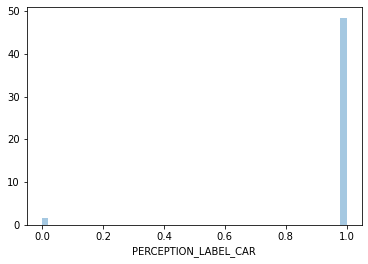

In [35]:
sns.distplot(label_probs_df['PERCEPTION_LABEL_CAR'])

/home/raman/anaconda3/envs/trajectory/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='PERCEPTION_LABEL_CYCLIST'>

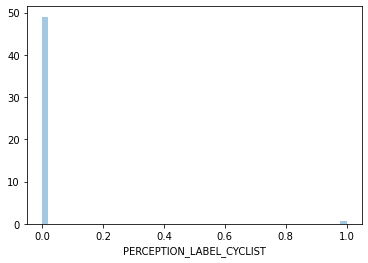

In [36]:
sns.distplot(label_probs_df['PERCEPTION_LABEL_CYCLIST'])

/home/raman/anaconda3/envs/trajectory/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='PERCEPTION_LABEL_PEDESTRIAN'>

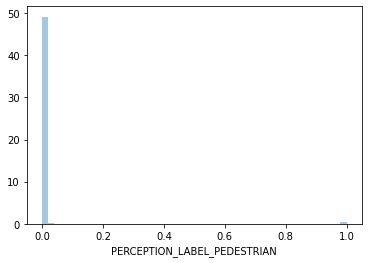

In [37]:
sns.distplot(label_probs_df['PERCEPTION_LABEL_PEDESTRIAN'])